In [1]:
import json
import os
import numpy as np
import itertools

from transformers import PreTrainedTokenizerFast, AutoTokenizer, AutoConfig
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
from notebook_utils import *

# Properties of Trained Tokenizers (for specific sizes)

In [3]:
tokenizer_dir = "/home/limisiewicz/my-luster/entangled-in-scripts/tokenizers"

languages = ('ar', 'tr', 'zh','el', 'es', 'en')
multil_string = '-'.join(languages)

alpha = '0.0'
#if alpha != '0.0':
#    languages = ('ar', 'tr','el', 'es', 'en')

NV_monos = (20000, 30000, 40000)
NV_multis = (120000, 180000, 240000)

tok_type = "sp-unigram"

In [4]:
mono_tokenizers = {}
multi_tokenizer = {}


for nv_mono, nv_multi in zip(NV_monos, NV_multis):
    multi_tokenizer[nv_multi] = get_tokenizer(tokenizer_dir, tok_type, multil_string, alpha, nv_multi)
    mono_tokenizers[nv_mono] = {}
    for lang in languages:
        mono_tokenizers[nv_mono][lang] = get_tokenizer(tokenizer_dir, tok_type, lang,alpha, nv_mono)

/ha/home/limisiewicz/.virtualenvs/eis/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1679: FutureWarning: Calling PreTrainedTokenizerFast.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  warnings.warn(
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LEDTokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LEDTokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
The tokenizer class you load from this checkpoint is not the same

### Measure size of alphabet in the vocab

In [5]:
alphabet_sizes = {}
for lang in languages:
    alphabet_sizes[lang] = np.array([get_alphabet_size(mono_tokenizers[nv_mono][lang])
                                     for nv_mono in NV_monos])

alphabet_sizes["multilingual"] = np.array([get_alphabet_size(multi_tokenizer[nv_multi]) 
                                           for nv_multi in NV_multis])

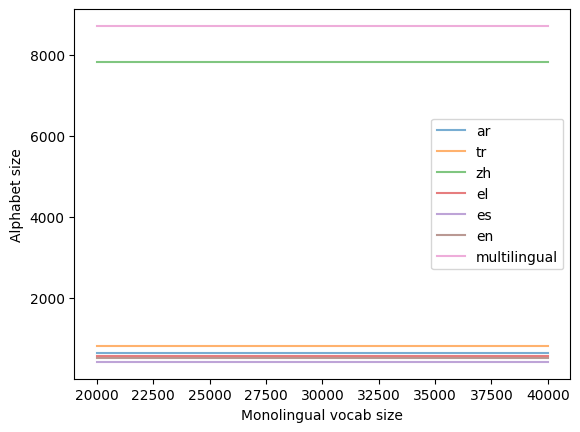

In [6]:
plt.figure()

for lang, alphabet_size in alphabet_sizes.items():
    plt.plot(NV_monos, alphabet_size, label=lang, alpha=0.6)
    
plt.xlabel("Monolingual vocab size")
plt.ylabel("Alphabet size")
plt.legend()

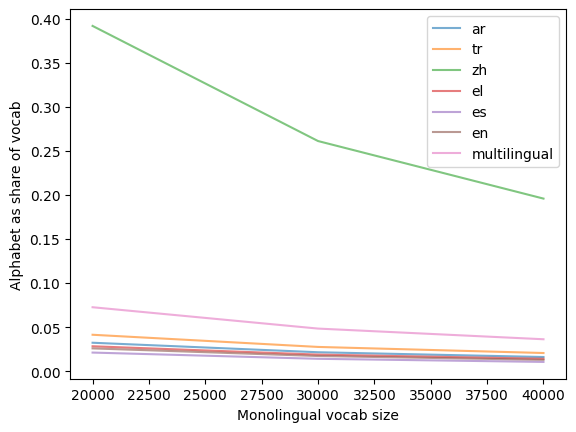

In [7]:
plt.figure()

for lang, alphabet_size in alphabet_sizes.items():
    if lang == "multilingual":
        plt.plot(NV_monos, alphabet_size/NV_multis, label=lang, alpha=0.6)
    else:
        plt.plot(NV_monos, alphabet_size/NV_monos, label=lang, alpha=0.6)
    
plt.xlabel("Monolingual vocab size")
plt.ylabel("Alphabet as share of vocab")
plt.legend()

### Measure token acceptance in m-lingual vocab

In [8]:
accepted_shares = {}
for lang in languages:
    accepted_shares[lang] = np.array([tokens_acceptance(mono_tokenizers[nv_mono][lang],
                                                       multi_tokenizer[nv_multi]) for nv_mono, nv_multi in 
                                      zip(NV_monos, NV_multis)])

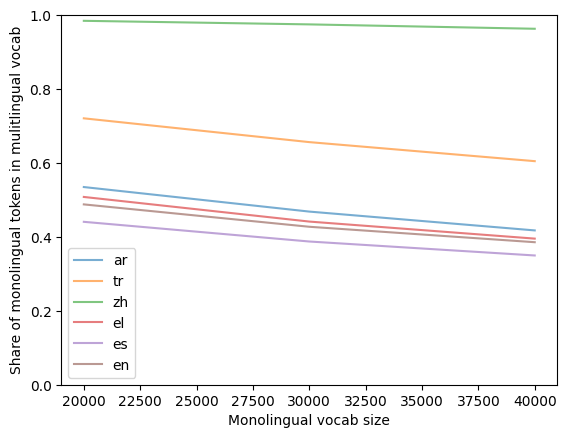

In [9]:
plt.figure()

for lang, accepted_share in accepted_shares.items():
        plt.plot(NV_monos, accepted_share, label=lang, alpha=0.6)
    
plt.xlabel("Monolingual vocab size")
plt.ylabel("Share of monolingual tokens in mulitlingual vocab")
plt.ylim([0.0, 1.0])
plt.legend()

### Measure overlap between languages

In [10]:
all_overlap_shares_exact = np.array([tokens_overlap_exact([mono_tokenizers[nv_mono][lang] for lang in languages],
                                                    multi_tokenizer[nv_multi])
                                     for nv_mono, nv_multi in zip(NV_monos, NV_multis)])

Text(0, 0.5, 'Overlap between all languages')

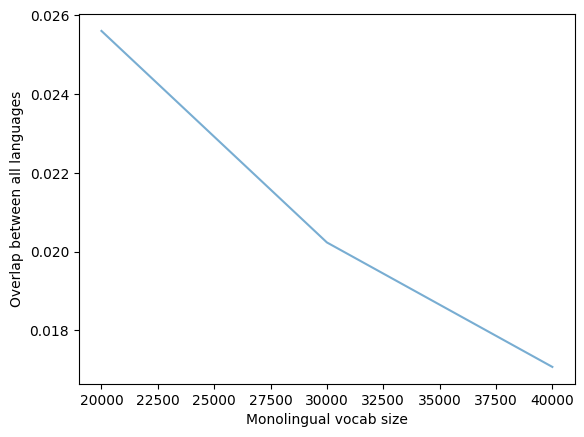

In [11]:
plt.figure()

plt.plot(NV_monos, all_overlap_shares_exact, alpha=0.6)
    
plt.xlabel("Monolingual vocab size")
plt.ylabel("Overlap between all languages")

## Measuring Overlap between pairs of languages

In [12]:
overlap_maps = {}

for nv_mono, nv_multi in zip(NV_monos, NV_multis):
    overlap_list = []
    for lang1, lang2 in itertools.product(languages, repeat=2):
        overlap_list.append(tokens_overlap_exact([mono_tokenizers[nv_mono][lang1],
                                                 mono_tokenizers[nv_mono][lang2]],
                                               multi_tokenizer[nv_multi]))
        
    overlpa_matrix = np.array(overlap_list).reshape((len(languages), len(languages)))
    overlap_maps[nv_mono] = overlpa_matrix

<Figure size 640x480 with 0 Axes>

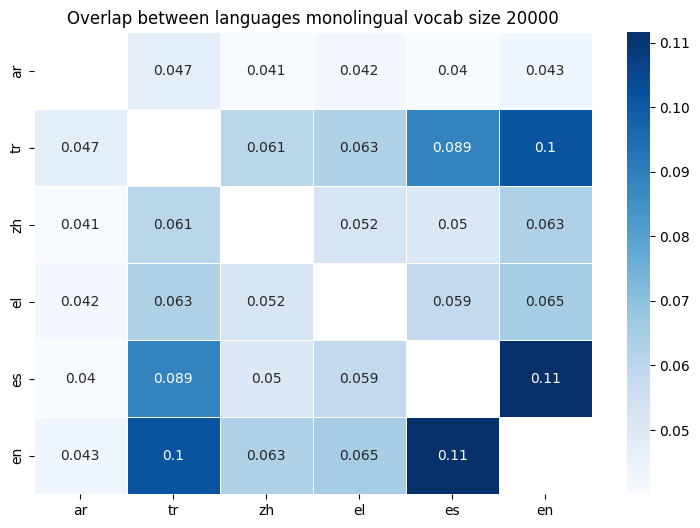

<Figure size 640x480 with 0 Axes>

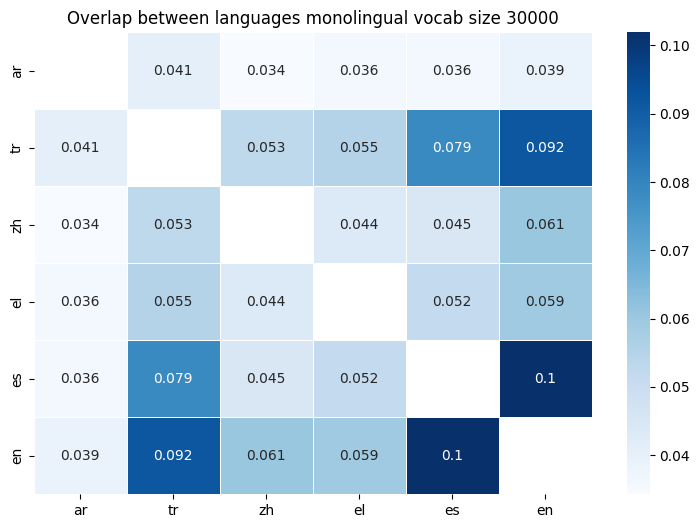

<Figure size 640x480 with 0 Axes>

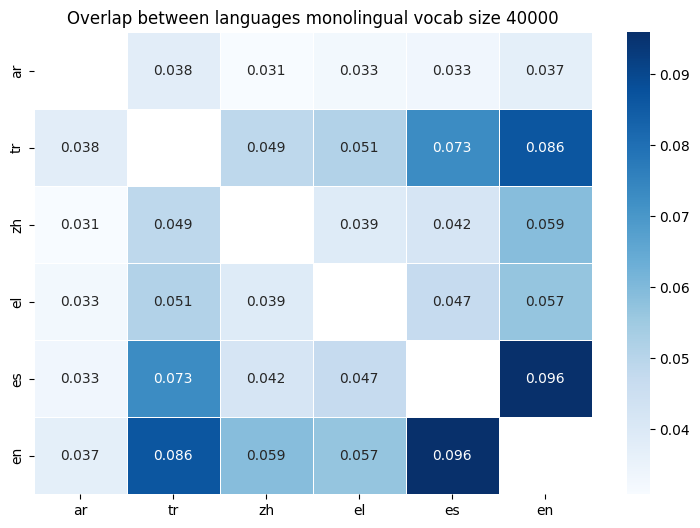

In [13]:
for nv_mono in NV_monos:
    plt.figure()



    f, ax = plt.subplots(figsize=(9, 6))
    
    np.fill_diagonal(overlap_maps[nv_mono], 0.0)

    
    mask = np.eye(overlap_maps[nv_mono].shape[0], dtype='bool')
    sns.heatmap(overlap_maps[nv_mono], annot=True, mask=mask, linewidths=.5, ax=ax, cmap="Blues")


    ax.set_xticks(np.arange(len(languages)) + 0.5, labels=languages)
    ax.set_yticks(np.arange(len(languages)) + 0.5, labels=languages)

    ax.set_title(f"Overlap between languages monolingual vocab size {nv_mono}")
    plt.show()

# Without alphabet

In [14]:
overlap_maps_no_alphabet = {}

for nv_mono, nv_multi in zip(NV_monos, NV_multis):
    overlap_list = []
    for lang1, lang2 in itertools.product(languages, repeat=2):
        overlap_list.append(tokens_overlap_exact_no_alphabet([mono_tokenizers[nv_mono][lang1],
                                                 mono_tokenizers[nv_mono][lang2]],
                                               multi_tokenizer[nv_multi]))
        
    overlpa_matrix = np.array(overlap_list).reshape((len(languages), len(languages)))
    overlap_maps_no_alphabet[nv_mono] = overlpa_matrix

<Figure size 640x480 with 0 Axes>

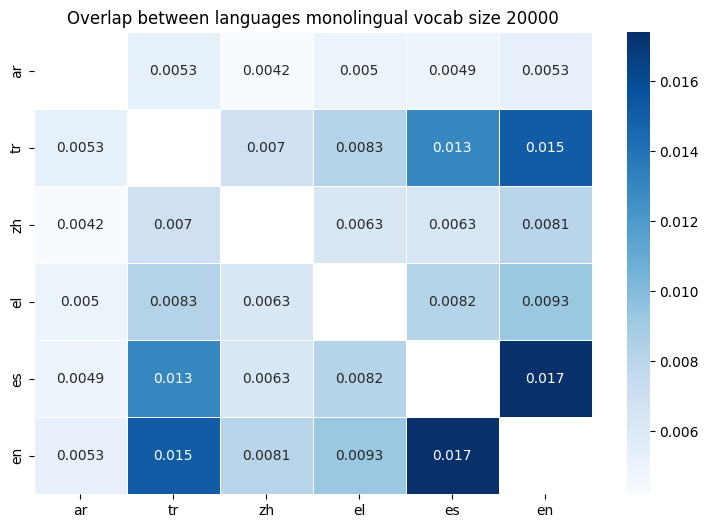

<Figure size 640x480 with 0 Axes>

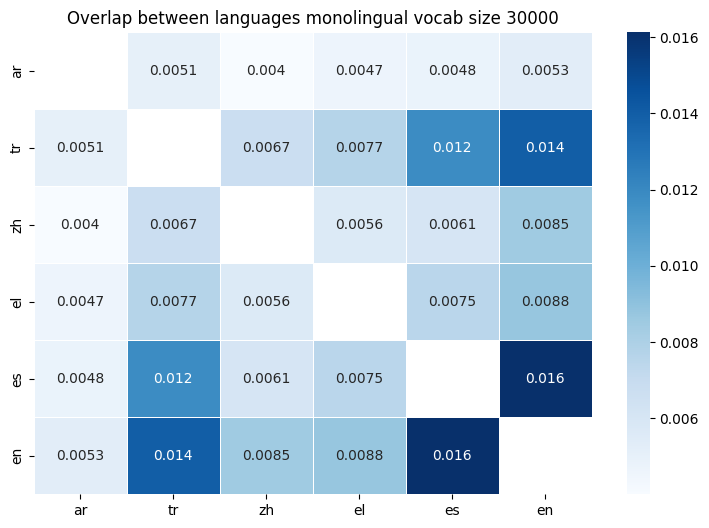

<Figure size 640x480 with 0 Axes>

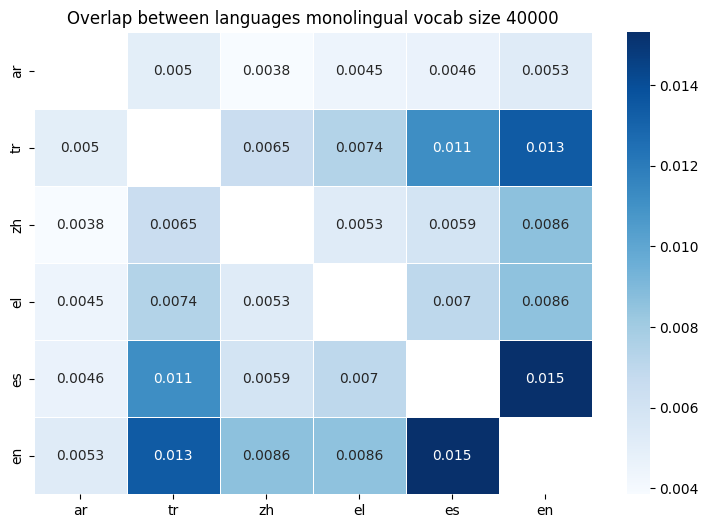

In [15]:
for nv_mono in NV_monos:
    plt.figure()



    f, ax = plt.subplots(figsize=(9, 6))
    
    np.fill_diagonal(overlap_maps_no_alphabet[nv_mono], 0.0)

    
    mask = np.eye(overlap_maps_no_alphabet[nv_mono].shape[0], dtype='bool')
    sns.heatmap(overlap_maps_no_alphabet[nv_mono], annot=True, mask=mask, linewidths=.5, ax=ax, cmap="Blues")


    ax.set_xticks(np.arange(len(languages)) + 0.5, labels=languages)
    ax.set_yticks(np.arange(len(languages)) + 0.5, labels=languages)

    ax.set_title(f"Overlap between languages monolingual vocab size {nv_mono}")
    plt.show()